# Run this Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P2_CartPole_REINFORCE_Baseline.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-3-Questions/blob/main/HW3_P2_CartPole_REINFORCE_Baseline.ipynb)

# HW3: REINFORCE with and without baseline in CartPole
> - Full Name: **Ali Najar**
> - Student ID: **401102701**


This notebook implements the **REINFORCE policy gradient algorithm** to train an agent in the **CartPole-v1** environment. It also compares the performance of **REINFORCE with and without a baseline** to assess its impact on training stability and efficiency.  

**Grading Breakdown:**

- Practical Implementation: 70 points
- Conceptual Understanding: 30 points

# Setup

All required packages are pre-installed if using Google Colab.


Import the following libraries.

In [ ]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym
import matplotlib
import matplotlib.pyplot as plt
import base64
import imageio
import IPython
import logging
import warnings

# Disable warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

Configure Matplotlib for Interactive and XKCD-Style Plots

In [ ]:
# Set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

Record and Embed Simulation Videos in Jupyter Notebook

<b>embed_mp4:</b> Converts an MP4 video into a base64-encoded HTML tag for display in Jupyter Notebook.
<br>
<b>record_simulation:</b> Runs a policy in the environment, records the simulation, and saves it as an MP4 video.

In [ ]:
def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def record_simulation(env, policy_net, filename, episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(episodes):
            state = env.reset()
            frame = env.render()  # Capture the first frame
            video.append_data(frame[0])

            done = False
            while not done:
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                action = torch.argmax(policy_net(state_tensor)).item()
                state, _, terminated, truncated, _ = env.step(action)

                frame = env.render()  # Capture the frame after taking the action
                video.append_data(frame[0])

                done = terminated or truncated
    return embed_mp4(filename)

# Explore the environment  (5 points)

Initialize CartPole Environment and Display State & Action Spaces

In [ ]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

# Print observation and action space
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)

Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action Space: Discrete(2)


**Question 1: (5 points)**

How are the observation and action spaces defined in the CartPole environment?

ANSWER IN REPORT</br>


Define a Random Policy for Action Selection  

In [ ]:
class RandomPolicy(object):

    def __init__(self, action_space_n):
        self.action_space_n = action_space_n

    def __call__(self, state):
        action_values = torch.rand(self.action_space_n)
        return action_values

Visualize the random policy.

In [ ]:
random_policy = RandomPolicy(env.action_space.n)

record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), random_policy, "Video_CartPole_random_policy")

# Agent with REINFORCE: Baseline vs. No Baseline in CartPole-v1 (85 points)


### Policy Network Definition (5 points)

To define a neural network that represents the agent’s policy for selecting actions.

The policy network takes the environment’s state as input and outputs a probability distribution over possible actions.

In [ ]:
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, state):
        if state.dim() == 1:  # If state has shape (input_dim,), reshape it
            state = state.unsqueeze(0)
        x = F.relu(self.fc1(state))
        logits = self.fc2(x)
        action_probs = torch.softmax(logits, dim=-1)
        return action_probs


### Computing Discounted Returns (10 points)

To implement a function that calculates the discounted return for each timestep in an episode.

$$[
G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
]$$

In [ ]:
# Implement the function to compute discounted returns
def compute_returns(rewards, gamma=0.99):
    returns = torch.zeros(len(rewards), dtype=torch.float32, device=DEVICE)
    G = 0

    for t in reversed(range(len(rewards))):  # Iterate from last timestep to first
        G = rewards[t] + gamma * G
        returns[t] = G  # Store the return for timestep t

    return returns

**Question 2: (5 points)**

What is the role of the discount factor (𝛾) in reinforcement learning, and what happens when 𝛾=0 or 𝛾=1?

ANSWER IN REPORT</br>


### Implementing the REINFORCE Algorithm (Without Baseline) (20 points)

To train the agent using the standard policy gradient method.
The REINFORCE algorithm updates policy parameters by using the log-probability of actions multiplied by the discounted return.

This algorithm optimizes a **stochastic policy** $( \pi_{\theta}(a_t \mid s_t) )$ by updating its parameters in the direction that increases expected rewards. The update rule is based on the **policy gradient theorem**:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) G_t
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

- $( \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) )$ is the gradient of the log-probability of the selected action, used to adjust the policy in the correct direction.

In [ ]:
# Implement the REINFORCE algorithm without baseline
def reinforce(env, policy_net, optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []
    for episode in range(num_episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        done = False

        while not done:
            state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)

            action_probs = policy_net(state)  # Get action probabilities

            action_dist = torch.distributions.Categorical(action_probs)  # Create distribution
            action = action_dist.sample()  # Sample an action

            log_probs.append(action_dist.log_prob(action))  # Store log probability
            state, reward, done, _ = env.step(action.item())  # Take action
            rewards.append(reward)  # Store reward

        # Compute discounted returns
        returns = compute_returns(rewards, gamma)
        returns = torch.tensor(returns, dtype=torch.float32)

        # Compute policy loss
        policy_loss = []
        for log_prob, G_t in zip(log_probs, returns):
            policy_loss.append(-log_prob * G_t)

        policy_loss = torch.stack(policy_loss).sum()  # Sum loss over episode

        # Update policy
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Store episode reward
        rewards_per_episode.append(sum(rewards))



        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {sum(rewards)}")

    return rewards_per_episode

### Value Network Definition (Baseline Network) (5 points)

Defines a neural network that approximates the value function, which estimates the expected return from a given state. The network takes the environment’s state as input and outputs a scalar value, representing the long-term reward the agent can expect from that state.

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        value = self.fc2(x)
        return value


### Implementing REINFORCE with a Baseline (20 points)

To reduce variance in policy updates, we introduce a **baseline** function $( V(s) )$, which estimates the expected return from a given state. Instead of using the full return $( G_t )$, we adjust the policy update by incorporating the baseline:  

$$[
\theta \leftarrow \theta + \alpha \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) (G_t - V(s_t))
]$$

where:  

- $( \theta )$ are the policy parameters (weights of the neural network).  
- $( \alpha )$ is the learning rate.  
- $( G_t )$ is the **discounted return** from timestep $( t )$:  

  $$[
  G_t = \sum_{k=0}^{T-t} \gamma^k R_{t+k}
  ]$$

- $( V(s_t) )$ is the **baseline function**, estimated by a **value network**, which is trained using mean squared error (MSE) between predicted values and actual returns:  

  $$[
  L = \frac{1}{N} \sum_{t=0}^{N} (G_t - V(s_t))^2
  ]$$

The introduction of the baseline does not change the expected value of the gradient but significantly **reduces variance**, leading to more stable learning.  


In [ ]:
# Implement REINFORCE with baseline
def reinforce_with_baseline(env, policy_net, baseline_net, policy_optimizer, baseline_optimizer, num_episodes=1000, gamma=0.99):
    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()  # Reset environment
        log_probs = []
        rewards = []
        values = []
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            action_probs = policy_net(state_tensor)  # Get action probabilities
            value = baseline_net(state_tensor)  # Get state value estimate
            values.append(value.squeeze(0))

            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()  # Sample action

            log_probs.append(action_dist.log_prob(action))
            state, reward, done, _ = env.step(action.item())
            rewards.append(reward)

        # Compute discounted returns
        returns = compute_returns(rewards, gamma)
        returns = torch.tensor(returns, dtype=torch.float32)
        # Compute advantages
        values = torch.stack(values).squeeze(-1)
        advantages = returns - values.detach()  # Advantage function: A_t = G_t - V(s_t)

        # Policy Loss (REINFORCE with Baseline)
        policy_loss = (-torch.stack(log_probs) * advantages).sum()

        # Value Loss (Mean Squared Error)
        value_loss = torch.nn.functional.mse_loss(values, returns)

        # Update Policy Network
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # Update Value Network (Baseline)
        baseline_optimizer.zero_grad()
        value_loss.backward()
        baseline_optimizer.step()

        # Store episode reward
        rewards_per_episode.append(sum(rewards))

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {sum(rewards)}")

    return rewards_per_episode

**Question 3: (5 points)**

Why is a baseline introduced in the REINFORCE algorithm, and how does it contribute to training stability?

ANSWER IN REPORT</br>


### Training (10 points)

To define key hyperparameters that influence training efficiency and convergence.

Hyperparameters like learning rate, discount factor, and number of episodes significantly impact the training process. Proper tuning is necessary to ensure stable learning while avoiding slow convergence or premature convergence to suboptimal policies.

In [ ]:
# Define all necessary hyperparameters
INPUT_DIM = env.observation_space.shape[0]
OUTPUT_DIM = env.action_space.n
LEARNING_RATE = 1e-3
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 2000


# Initialize Policy and Baseline Networks
policy_net_no_baseline = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
policy_net_with_baseline = PolicyNetwork(INPUT_DIM, OUTPUT_DIM).to(DEVICE)
baseline_net = ValueNetwork(INPUT_DIM).to(DEVICE)

# Optimizers
policy_optimizer_no_baseline = optim.Adam(policy_net_no_baseline.parameters(), lr=LEARNING_RATE)
policy_optimizer_with_baseline = optim.Adam(policy_net_with_baseline.parameters(), lr=LEARNING_RATE)
baseline_optimizer = optim.Adam(baseline_net.parameters(), lr=LEARNING_RATE)

# Training
print("Training REINFORCE without Baseline:")
rewards_no_baseline = reinforce(env, policy_net_no_baseline, policy_optimizer_no_baseline, num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR)

print("\n--------------------------------------------------------------------\n")

print("Training REINFORCE with Baseline:")
rewards_with_baseline = reinforce_with_baseline(
    env, policy_net_with_baseline, baseline_net, policy_optimizer_with_baseline, baseline_optimizer,
    num_episodes=NUM_EPISODES, gamma=DISCOUNT_FACTOR
)


Training REINFORCE without Baseline:


<ipython-input-33-3f60e19dcd1c>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32)


Episode 50, Reward: 12.0
Episode 100, Reward: 71.0
Episode 150, Reward: 80.0
Episode 200, Reward: 230.0
Episode 250, Reward: 220.0
Episode 300, Reward: 227.0
Episode 350, Reward: 277.0
Episode 400, Reward: 250.0
Episode 450, Reward: 377.0
Episode 500, Reward: 273.0
Episode 550, Reward: 418.0
Episode 600, Reward: 210.0
Episode 650, Reward: 231.0
Episode 700, Reward: 237.0
Episode 750, Reward: 280.0
Episode 800, Reward: 500.0
Episode 850, Reward: 139.0
Episode 900, Reward: 307.0
Episode 950, Reward: 500.0
Episode 1000, Reward: 500.0
Episode 1050, Reward: 500.0
Episode 1100, Reward: 409.0
Episode 1150, Reward: 128.0
Episode 1200, Reward: 161.0
Episode 1250, Reward: 460.0
Episode 1300, Reward: 500.0
Episode 1350, Reward: 410.0
Episode 1400, Reward: 361.0
Episode 1450, Reward: 431.0
Episode 1500, Reward: 500.0
Episode 1550, Reward: 324.0
Episode 1600, Reward: 500.0
Episode 1650, Reward: 500.0
Episode 1700, Reward: 500.0
Episode 1750, Reward: 500.0
Episode 1800, Reward: 500.0
Episode 1850, R

<ipython-input-35-3064e8b5a45f>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32)


Episode 50, Reward: 24.0
Episode 100, Reward: 32.0
Episode 150, Reward: 46.0
Episode 200, Reward: 52.0
Episode 250, Reward: 75.0
Episode 300, Reward: 63.0
Episode 350, Reward: 121.0
Episode 400, Reward: 45.0
Episode 450, Reward: 97.0
Episode 500, Reward: 223.0
Episode 550, Reward: 346.0
Episode 600, Reward: 386.0
Episode 650, Reward: 215.0
Episode 700, Reward: 171.0
Episode 750, Reward: 500.0
Episode 800, Reward: 500.0
Episode 850, Reward: 305.0
Episode 900, Reward: 374.0
Episode 950, Reward: 500.0
Episode 1000, Reward: 500.0
Episode 1050, Reward: 269.0
Episode 1100, Reward: 500.0
Episode 1150, Reward: 500.0
Episode 1200, Reward: 500.0
Episode 1250, Reward: 500.0
Episode 1300, Reward: 500.0
Episode 1350, Reward: 500.0
Episode 1400, Reward: 500.0
Episode 1450, Reward: 500.0
Episode 1500, Reward: 500.0
Episode 1550, Reward: 407.0
Episode 1600, Reward: 500.0
Episode 1650, Reward: 500.0
Episode 1700, Reward: 500.0
Episode 1750, Reward: 500.0
Episode 1800, Reward: 281.0
Episode 1850, Reward

**Question 4: (5 points)**

What are the primary challenges associated with policy gradient methods like REINFORCE?

ANSWER IN REPORT</br>


# Plot and Comparing Results (10 points)

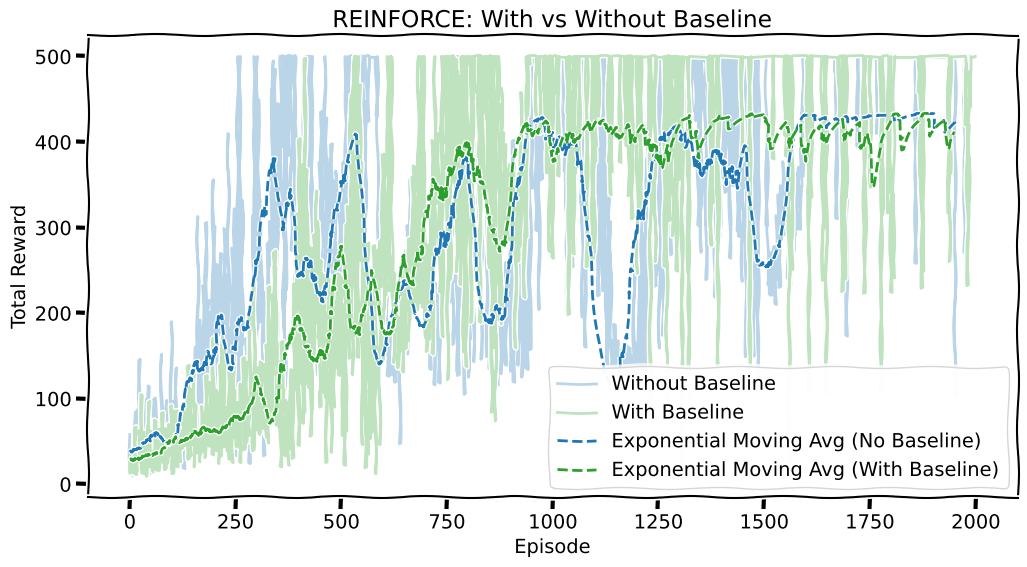

In [40]:
# Plotting Results
window_size = 50  # Moving average window size

# Exponential Moving Average calculation
def exponential_moving_average(data, window_size):
    alpha = 2 / (window_size + 1)  # Smoothing factor
    return np.convolve(data, [alpha * (1 - alpha) ** i for i in range(window_size)], mode='valid')

plt.plot(rewards_no_baseline, label="Without Baseline", alpha=0.3, color='tab:blue')
plt.plot(rewards_with_baseline, label="With Baseline", alpha=0.3, color='tab:green')

# Plotting exponential moving averages
plt.plot(exponential_moving_average(rewards_no_baseline, window_size), label="Exponential Moving Avg (No Baseline)", linestyle='--', color='tab:blue')
plt.plot(exponential_moving_average(rewards_with_baseline, window_size), label="Exponential Moving Avg (With Baseline)", linestyle='--', color='tab:green')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.title("REINFORCE: With vs Without Baseline")
plt.show()

In [41]:
mean_reward, std_reward = np.mean(rewards_no_baseline), np.std(rewards_no_baseline)
print(f"No Baseline: mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward, std_reward = np.mean(rewards_with_baseline), np.std(rewards_with_baseline)
print(f"With Baseline: mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

No Baseline: mean_reward = 340.61 +/- 161.5185
With Baseline: mean_reward = 346.92 +/- 179.2873


**Question 5:** (5 points)

Based on the results, how does REINFORCE with a baseline compare to REINFORCE without a baseline in terms of performance?

ANSWER IN REPORT</br>


**Question 6:** (5 points)

Explain how variance affects policy gradient methods, particularly in the context of estimating gradients from sampled trajectories.

ANSWER IN REPORT</br>

# Simulation

In [42]:
# Record the simulation using the optimal policy no baseline
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy_net_no_baseline, "Video_CartPole_no_baseline")

In [43]:
# Record the simulation using the optimal policy with baseline
record_simulation(gym.make("CartPole-v1", render_mode='rgb_array', new_step_api=True), policy_net_with_baseline, "Video_CartPole_with_baseline")